In [1]:
#Make sure to mount GPU. Go to Runtime > Change Runtime Type > Select GPU option from dropdown
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
import os
import csv
import json
import pandas as pd
import numpy as np
import string
import torch
from torch.utils.data import TensorDataset
from tqdm import notebook
import itertools
import seaborn as sns
from google.cloud import bigquery
from google.cloud import storage
from datetime import date
from google.colab import files, auth, drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
drive.mount('/content/gdrive')
auth.authenticate_user()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!pip install transformers

     |████████████████████████████████| 778kB 2.7MB/s 
     |████████████████████████████████| 890kB 14.2MB/s 
     |████████████████████████████████| 3.0MB 13.2MB/s 
     |████████████████████████████████| 1.1MB 32.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=0ab6c81769acde1747a979974659b4808a440b23f8881b514dce253b58c1c41c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
def regex_filter(df):
  df["final_utterance"] = df["final_utterance"].str.lower()

  regex_patterns={
      # replace "uh.," "um.," "ah.," "mm.,", "oh.,!?" with blank but we leave uh-hum/mm-hmm in there
      r'(\buh(\,|\.|\s|\?))': ' ',
      r'(\bum(\,|\.|\s|\?))': ' ',
      r'(\bah\W)': ' ',
      r'(\bmm(\,|\.|\s|\!|\?))': ' ',
      r'(\boh(\,|\.|\s|\!|\?))': ' ',

      r'(\s*(?:\+?(\d{1,3}))?[-. (]*(\d{3})?[-. )]*(\d{3})[-. ]*(\d{4})(?: *x(\d+))?\s*)': ' ', # remove 10 digit and 7 digit numbers  e.g., 456-123-0000 and 123-0000
      r'(\d{3,})': '', # remove any numbers that has length 3 or more 
      r'\b(\w+)((?:\W+?)(\s+)?\1\b)+': r'\1', # replaces duplicate words with a single instance of that word. "yup, yup thank thank you. bye-bye" -> "yup thank you. bye" 
      r'([a-zA-Z0-9._-]+(\s+)?@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)': '[email]',
      r'(\bok\b)': 'okay',  #replaces "ok" with "okay"
      r'(ma\'am)': 'madam', #replaces ma'am with madam 
      r'(\s{2,})': ' '#replaces 2 or more whitespaces with a single one
  }

  df['final_utterance'].replace(regex=regex_patterns, inplace=True)
  df['final_utterance'] = df['final_utterance'].str.strip() 

  return df

def get_duration_col(df):
  df_min = df.groupby(['call_id'])['time_start'].min().reset_index()
  df_max = df.groupby(['call_id'])['time_end'].max().reset_index()
  df_time = pd.merge(df_min, df_max, on='call_id')
  df_time['duration'] = df_time.time_end - df_time.time_start

  # combine all the utterances grouped by the call_id into a single conversation. 
  df_combined = df.groupby(['call_id', 'response_value']).agg({'final_utterance': ' '.join}).reset_index()
  dfr = pd.merge(df_combined, df_time[['call_id', 'duration']], on='call_id')

  return dfr

def encode_labels(df):
  filter_method = lambda x: 0 if x < 3 else 1 if (x >3) else None
  df['response_value'] = df.response_value.apply(filter_method)
  df = df[df['response_value'].notna()]
  
  return df

def exclude_disconnected_calls(df):
  dfn = df[df.text_length.gt(30)].reset_index()

  dfn["last_10_words"] = dfn['text'].str.split().str[-10:].str.join(" ").str.strip() 
  dfn["last_65_words"] = dfn['text'].str.split().str[-65:].str.join(" ").str.strip() 

  dropcall_words = ['one moment', 'hello', 'hold on', 'on hold', 'brief hold', 'hang tight','one second', 'breaking up', 'breaking in', 'transfer', 'hear me', 'hear you', 'hung up', 'disconnect']
  bye_words = ['bye', 'see you', 'talk to you', 'appreciate', 'good', 'great']
  survey_words = ['following this call','participate','survey','one question','bye','great day','great weekend','good day', 'good weekend', 'wonderful day', 'wonderful weekend','see you','welcome']

  # drop all calls related to disconnection / does not make sense / seem to get disconnected unexpectedly.
  dfn = dfn[~((dfn.text_length < 100) & 
          ((dfn['last_10_words'].str.contains('|'.join(dropcall_words))) | (~dfn['last_10_words'].str.contains('|'.join(bye_words)))))]

  #There seems to be many calls where the agent explicitly tells the customer that there will be a one question survey at the end of the call 
  #so to exclude these calls, i'll search for particular strings in the last 65 words. 
  dfn = dfn[~((dfn.text_length >= 100) & 
      (
          ((dfn['last_10_words'].str.contains('|'.join(dropcall_words))) & (~dfn['last_10_words'].str.contains('|'.join(bye_words)))) | 
          ((dfn['last_10_words'].str.contains('|'.join(dropcall_words))) & (~dfn['last_65_words'].str.contains('|'.join(survey_words))))
      )
  )]

  return dfn

def get_last_768_tokens(text):
  #We tokenize using XLNet's sentencepiece tokenizer into their respective ids and take only the last 768 tokens
  ids = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(inputs)[-768:]) for inputs in notebook.tqdm(text)]

  #We decode the ids back into text to use the encode_plus function
  ids_to_text = [tokenizer.decode(inputs) for inputs in notebook.tqdm(ids)]

  return ids_to_text

## The following code is to get all the calls including disconnected calls 

---



In [ ]:
project_id = 'talkiq-data'
client = bigquery.Client(project=project_id)

query = """
SELECT *
FROM `talkiq-data.ai_research.csat_utterance`
"""

df = client.query(query).to_dataframe()
df[['response_value']] = df[['response_value']].astype(str).astype(int)

#Removing duplicate utterances. 
#Example of a call with duplicate utterances: df[df.call_id == '5774478919204864']
temp_df = df.sort_values(by=['call_id','time_start','PARTITIONTIME'])
df1 = temp_df.drop_duplicates(subset=['final_utterance','call_leg_id'], keep='last')
df2 = regex_filter(df1)
df3 = get_duration_col(df2)
df4 = encode_labels(df3)

df4['text_length'] = df4['final_utterance'].str.split().str.len()
df4 = df4[df4.text_length > 5]
df4['text'] = df4['final_utterance'].str.replace(r'[^\w\s]+', '')

# Import Drive API and authenticate.
# from google.colab import drive

# Mount your Drive to the Colab VM.
# drive.mount('/gdrive')

# Write the DataFrame to CSV file.
# with open('/gdrive/My Drive/csatBERT/csat_final_including_disconnected.csv', 'w') as f:
  # df4.to_csv(f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Mounted at /gdrive


## The following code is to get all the calls EXCLUDING disconnected calls (only connected calls)


In [ ]:
project_id = 'talkiq-data'
client = bigquery.Client(project=project_id)

query = """
SELECT *
FROM `talkiq-data.ai_research.csat_utterance`
"""

df = client.query(query).to_dataframe()
df[['response_value']] = df[['response_value']].astype(str).astype(int)

#Removing duplicate utterances. 
#Example of a call with duplicate utterances: df[df.call_id == '5774478919204864']
temp_df = df.sort_values(by=['call_id','time_start','PARTITIONTIME'])
df1 = temp_df.drop_duplicates(subset=['final_utterance','call_leg_id'], keep='last')
df2 = regex_filter(df1)
df3 = get_duration_col(df2)
df4 = encode_labels(df3)

df4['text_length'] = df4['final_utterance'].str.split().str.len()
df4 = df4[df4.text_length > 5]
df4['text'] = df4['final_utterance'].str.replace(r'[^\w\s]+', '')

df5 = exclude_disconnected_calls(df4)


# Import Drive API and authenticate.
# from google.colab import drive

# # Mount your Drive to the Colab VM.
# drive.mount('/gdrive')

# # Write the DataFrame to CSV file.
# with open('/gdrive/My Drive/csatBERT/csat_final.csv', 'w') as f:
#   df4.to_csv(f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [5]:
# drive.mount('/content/gdrive')
# df= pd.read_csv('gdrive/My Drive/csat_final.csv',index_col=0)

project_id = 'talkiq-data'
client = bigquery.Client(project=project_id)

query = """
WITH companies as 
(SELECT DISTINCT(call_id), org, MIN(PARTITIONTIME) as PARTITIONTIME
FROM `talkiq-data.data_science_pii.tastes_utterances_final`
GROUP BY call_id, org)

SELECT b.org as company_id, comp.name as company_name ,a.call_id, a.response_value, a.final_utterance, a.duration, a.text, b.PARTITIONTIME
FROM `talkiq-data.ai_research.csat_prediction` a LEFT JOIN companies b ON a.call_id = CAST(b.call_id as INT64)
LEFT JOIN `firespotter.com:firespotter-analytics.uv_entities.Company` comp ON b.org = CAST(comp.primary_office_id AS STRING)
"""

df = client.query(query).to_dataframe()  

df.head()

,company_id,company_name,call_id,response_value,final_utterance,duration,text,PARTITIONTIME
0,4635704862244864,None,4517987021553664,1.0,"morning james. good morning, listen to jan. ho...",195.749,morning james good morning listen to jan how a...,2020-06-18 00:00:00+00:00
1,6014080632619008,SecurityMetrics,4903583396790272,1.0,thank you for calling security metrics. my nam...,1085.630,thank you for calling security metrics my name...,2019-10-08 00:00:00+00:00
2,6690660481564672,CareLinx HR,4982215506722816,1.0,thank you for calling carelinx assistance. how...,55.170,thank you for calling carelinx assistance how ...,2020-05-22 00:00:00+00:00
3,5171131407663104,Roadrunner Financial,5166395171078144,0.0,connection is really poor you there? hello? i ...,33.600,connection is really poor you there hello i ca...,2020-02-12 00:00:00+00:00
4,6024833421344768,Alta Pest Control,5338903318167552,1.0,thank you for calling auto pest control. this ...,171.237,thank you for calling auto pest control this i...,2020-07-06 00:00:00+00:00


In [6]:
# We tokenize the texts using XLNet's Tokenizer to get the total token length of each record
# Load the XLNet tokenizer.
from transformers import XLNetTokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
df['xlnet_tokenizer_length_no_punc'] = df.text.apply(lambda x: len(tokenizer.tokenize(x)))

In [7]:
#Check to see if there are any null values. We see that not every call has a organization name or id
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27213 entries, 0 to 27212
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   company_id                      26973 non-null  object             
 1   company_name                    26893 non-null  object             
 2   call_id                         27213 non-null  int64              
 3   response_value                  27213 non-null  float64            
 4   final_utterance                 27213 non-null  object             
 5   duration                        27213 non-null  float64            
 6   text                            27213 non-null  object             
 7   PARTITIONTIME                   26973 non-null  datetime64[ns, UTC]
 8   xlnet_tokenizer_length_no_punc  27213 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(4)
memory usage: 1.9+ MB


In [8]:
#We drop the rows where we don't have a company name
df = df[~df['company_name'].isnull()]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26893 entries, 1 to 27212
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   company_id                      26893 non-null  object             
 1   company_name                    26893 non-null  object             
 2   call_id                         26893 non-null  int64              
 3   response_value                  26893 non-null  float64            
 4   final_utterance                 26893 non-null  object             
 5   duration                        26893 non-null  float64            
 6   text                            26893 non-null  object             
 7   PARTITIONTIME                   26893 non-null  datetime64[ns, UTC]
 8   xlnet_tokenizer_length_no_punc  26893 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(4)
memory usage: 2.1+ MB


In [10]:
df.company_name.value_counts().sort_values(ascending=False)

Romanoff Renovations                    12662
TheStreet                                6440
Montway Inc                              2134
Hotel Engine                             1171
Top Turf                                  655
Arrive Mobility Inc                       628
Dialpad, Inc.                             585
10 Fitness                                390
Vinesse                                   296
Happy Home Appliance Repair Services      232
iNSYNQ LLC                                215
Deputy                                    211
Rocket Matter                             145
Service Legends                           136
Roadrunner Financial                      133
Ace Solves It All                         129
CareLinx HR                               110
Jackson Comfort Systems                   110
INDECS                                    104
Alta Pest Control                          90
PEG Primary                                65
Art's Way Manufacturing           

In [11]:
#Decide to use these orgs as held out orgs
held_out_orgs = df.company_name.value_counts().sort_values(ascending=False)[7:19].index.tolist()
held_out_orgs

['10 Fitness',
 'Vinesse',
 'Happy Home Appliance Repair Services',
 'iNSYNQ LLC',
 'Deputy',
 'Rocket Matter',
 'Service Legends',
 'Roadrunner Financial',
 'Ace Solves It All',
 'CareLinx HR',
 'Jackson Comfort Systems',
 'INDECS']

### Checking Class Distribution



In [12]:
df.groupby(['response_value'])['call_id'].nunique() #12.82% = minority class

response_value
0.0     3438
1.0    23455
Name: call_id, dtype: int64

### Process data to be XLNet-ready

In [13]:
#Decided to use these few organisations as hold out set 
df_train_valid = df[~df['company_name'].str.contains('|'.join(held_out_orgs))]
df_test = df[df['company_name'].str.contains('|'.join(held_out_orgs))]

In [14]:
#Checking class distribution of train, valid and test set. 
print(df_train_valid.response_value.value_counts()[0]/ len(df_train_valid))
print(df_test.response_value.value_counts()[0]/ len(df_test))

0.11721092293979418
0.2464947987336047


In [15]:
#Encoding train_valid set
text = df_train_valid.text.values
label = df_train_valid.response_value.values

#Get the last 768 tokens of calls that are > 768 tokens.
ids_to_text = get_last_768_tokens(text)
encoded_inputs = [tokenizer.encode_plus(inputs, max_length=770, pad_to_max_length=True, truncation=True, return_tensors='pt') for inputs in notebook.tqdm(ids_to_text)]

#Creating a tensor dataset with the ENCODED inputs, labels and attention tensors.  
trainvalid_inputs_tensor = torch.cat([x['input_ids'] for x in encoded_inputs])
trainvalid_attn_tensor = torch.cat([x['attention_mask'] for x in encoded_inputs])
trainvalid_labels_tensor = torch.LongTensor(label)


#Encoding test set
text = df_test.text.values
label = df_test.response_value.values

#Get the last 768 tokens of calls that are > 768 tokens.
ids_to_text = get_last_768_tokens(text)
encoded_inputs = [tokenizer.encode_plus(inputs, max_length=770, pad_to_max_length=True, truncation=True, return_tensors='pt') for inputs in notebook.tqdm(ids_to_text)]

#Creating a tensor dataset with the ENCODED inputs, labels and attention tensors.  
test_inputs_tensor = torch.cat([x['input_ids'] for x in encoded_inputs])
test_attn_tensor = torch.cat([x['attention_mask'] for x in encoded_inputs])
test_labels_tensor = torch.LongTensor(label)

## Train / Valid / Test Stratified Split

To get train, validation and test set, we need to perform 2 splits.
* First, we split the original dataframe for a 80-20 split. 
* Next, we split the former 20%-split by 50/50 to get our validation and test set. 

**More importantly, we stratify the split so that we maintain the same class imbalance ratio for train, valid and test sets**

In [16]:
# First split is a 90/10 split 
X_train, X_valid, attn_train, attn_valid, y_train, y_valid = train_test_split(trainvalid_inputs_tensor, trainvalid_attn_tensor, trainvalid_labels_tensor, random_state=42, test_size=0.1, stratify=trainvalid_labels_tensor)

print("Train size:", len(y_train), "\nValidation size:", len(y_valid), "\nTest size:", len(test_labels_tensor),"\n")

#Check to see that we have successfully divided and stratified the data correctly for train, validation, and test set
print("Train negative class count:", y_train.tolist().count(0))
print("Train positive class count:", y_train.tolist().count(1))
print("Minority class imbalance %:", y_train.tolist().count(0)/len(y_train),"\n")

print("Validation negative class count:", y_valid.tolist().count(0))
print("Validation positive class count:", y_valid.tolist().count(1))
print("Minority class imbalance %:", y_valid.tolist().count(0)/len(y_valid),"\n")

print("Test negative class count:", test_labels_tensor.tolist().count(0))
print("Test positive class count:", test_labels_tensor.tolist().count(1))
print("Minority class imbalance %:", test_labels_tensor.tolist().count(0)/len(test_labels_tensor))

Train size: 22213 
Validation size: 2469 
Test size: 2211 

Train negative class count: 2604
Train positive class count: 19609
Minority class imbalance %: 0.11722864988970423 

Validation negative class count: 289
Validation positive class count: 2180
Minority class imbalance %: 0.1170514378290806 

Test negative class count: 545
Test positive class count: 1666
Minority class imbalance %: 0.2464947987336047


## Oversampling Training Data For Class Imbalance

To deal with class imbalance, we will oversample the training data so that the classes will be balanced (50/50)

In [17]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="minority", random_state=42)

#Resample our text and values data 
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

#We also need to make sure we resample our attention tokens
attn_train_resampled, _ = ros.fit_resample(attn_train, y_train)

#Check to make sure the minority class is now balanced.
print("Class balance:", y_train_resampled.tolist().count(0) / (y_train_resampled.tolist().count(0) + y_train_resampled.tolist().count(1)))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Class balance: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [18]:
train_df = TensorDataset(torch.from_numpy(X_train_resampled), torch.from_numpy(attn_train_resampled), torch.from_numpy(y_train_resampled))
valid_df = TensorDataset(X_valid, attn_valid, y_valid)
test_df = TensorDataset(test_inputs_tensor, test_attn_tensor, test_labels_tensor) 

#sample subset for debugging 
# aa_df = TensorDataset(torch.from_numpy(X_train_resampled[:1992]), torch.from_numpy(attn_train_resampled[:1992]), torch.from_numpy(y_train_resampled[:1992]))
# bb_df = TensorDataset(X_test[:100], attn_test[:100], y_test[:100])

In [19]:
from torch.utils.data import DataLoader
from transformers import (XLNetConfig,
                        XLNetForSequenceClassification,
                        AdamW,
                        get_cosine_schedule_with_warmup)

## Freezing layers

Before training, we make sure to freeze all the other layers except the classifier layer. In XLNet, the classifier layer is defined as `logits_proj.weight` and `logits_proj.bias`. To freeze all the other layers, we set `param.requires_grad = False`, leaving only the logit layers to be `True`

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

class csatXLNet:
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

  def __init__(self,
               xlnet_pretrained_model='xlnet-base-cased', #'xlnet-base-cased'
               freeze_layers = True,
               train_batch_size=4,
               eval_batch_size=4,
               num_labels=2):

      # define hyperparameters
      self.train_batch_size = train_batch_size
      self.eval_batch_size = eval_batch_size
      self.num_labels = num_labels

      # loading pre-trained models
      self.config = XLNetConfig.from_pretrained(xlnet_pretrained_model)
      self.config.num_labels = num_labels
      self.model = XLNetForSequenceClassification.from_pretrained(xlnet_pretrained_model, config=self.config).to(self.DEVICE)

      self.train_dset = train_df
      self.eval_dset = valid_df
      self.train_loader = DataLoader(self.train_dset,
                                  batch_size=self.train_batch_size,
                                  shuffle=True)
      self.eval_loader = DataLoader(self.eval_dset,
                                  batch_size=self.eval_batch_size)
      
      #Freezing all layers except classifier layer
      if freeze_layers:
        for name, param in self.model.named_parameters():
          if 'logits_proj' not in name: # classifier layer for XLNet
            param.requires_grad = False

  def train_model(self,
                  num_epochs=10,
                  learning_rate=2e-4,
                  warmup_ratio=0.1,
                  experiment_path = '/content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/',
                  model_save_path = 'saved_model_epoch_%d/',
                  train_valid_filename = 'train_valid_stats.csv'):
    
    if not os.path.exists(experiment_path):
        os.makedirs(experiment_path)
  
    # Total number of training steps is [number of batches] x [number of epochs]. 
    num_total_steps = len(self.train_loader) * num_epochs 

    num_warmup_steps = int(num_total_steps * warmup_ratio)

    # instantiate optimizer

    # param_optimizer = list(self.model.named_parameters())
    # no_decay = ['bias', 'gamma', 'beta']
    # optimizer_grouped_parameters = [
    #     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    #     'weight_decay_rate': 0.01},
    #     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    #     'weight_decay_rate': 0.0}
    # ]

    optimizer = AdamW(self.model.parameters(),
                      lr=learning_rate) #default is 5e-5
                      

    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                      num_warmup_steps=num_warmup_steps,
                                      num_training_steps=num_total_steps)

    # define empty lists and counters to keep track of metrics
    train_valid_stats = []
    all_train_loss, all_train_accuracy, all_train_f1score, all_train_precision, all_train_recall = [], [], [], [], []
    all_eval_loss, all_eval_accuracy, all_eval_f1score, all_eval_precision, all_eval_recall = [], [], [], [], []

    self.model.train()

    with open(experiment_path + train_valid_filename, 'w') as csvfile:
      fieldnames = ['Epoch', 'train_loss', 'train_acc', 'train_f1', 'train_precision', 'train_recall', 'valid_loss', 'valid_acc', 'valid_f1', 'valid_precision', 'valid_recall', 'eval_confmat']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',')
      writer.writeheader()

      # loop over dataset for num_epochs
      for epoch in notebook.tqdm(range(num_epochs), desc="Epoch  "):
          print("")
          print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))

          t0 = time.time()

          # Reset the total loss for every new epoch.
          total_train_loss = 0
          total_train_acc = 0
          total_train_f1 = 0
          total_train_precision = 0
          total_train_recall = 0

          # loop over every batch within the training dataset
          for iter, (inputs, attns, labels) in enumerate(notebook.tqdm(self.train_loader, desc="Training")):
            
              # reset optimizer gradient
              optimizer.zero_grad()

              # putting inputs to device
              inputs = inputs.to(self.DEVICE)
              attns = attns.to(self.DEVICE)
              labels = labels.to(self.DEVICE)

              # feed to model
              outputs = self.model(inputs,
                              token_type_ids=None, 
                              attention_mask=attns,
                              labels=labels)
              
              loss, scores = outputs[:2]

              total_train_loss += loss.item()

              predictions = torch.argmax(scores, dim=-1)

              # backprop
              loss.backward()
              # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
              # Update parameters and take a step using the computed gradient.
              optimizer.step()
              #Update learning rate
              scheduler.step()

              total_train_acc += accuracy_score(labels.cpu().detach().numpy(), predictions.cpu().detach().numpy())
              _train_precision, _train_recall, _train_f1, _ = precision_recall_fscore_support(labels.cpu().detach().numpy(), predictions.cpu().detach().numpy(), average='weighted')
              total_train_precision += _train_precision
              total_train_recall += _train_recall
              total_train_f1 += _train_f1

              # # Progress update every 1306 samples.
              # if iter % 1306 == 0 and not iter == 0:

              #     # Calculate elapsed time in minutes.
              #     elapsed = format_time(time.time() - t0)
                  
              #     # Report progress.
              #     print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(iter, len(self.train_loader), elapsed))

          # add to totals 
          avg_train_loss = total_train_loss/len(self.train_loader)
          avg_train_acc = total_train_acc/len(self.train_loader)
          avg_train_f1 = total_train_f1/len(self.train_loader)
          avg_train_precision = total_train_precision/len(self.train_loader)
          avg_train_recall = total_train_recall/len(self.train_loader)

          # ========================================
          #               Validation
          # ========================================
          # After the completion of each training epoch, measure our performance on our validation set.

          eval_loss, eval_acc, eval_f1, eval_precision, eval_recall, eval_conf_matrix = self.evaluate_model()

          print("  Training Loss: {0:.4f}".format(avg_train_loss), "||", "Evaluation Loss: {0:.4f}".format(eval_loss)) 
          print("  Training Accuracy: {0:.4f}".format(avg_train_acc), "||", "Evaluation Accuracy: {0:.4f}".format(eval_acc))
          print("  Training F1: {0:.4f}".format(avg_train_f1), "||", "Evaluation F1: {0:.4f}".format(eval_f1)) 
          print("  Training Precision: {0:.4f}".format(avg_train_precision), "||", "Evaluation Precision: {0:.4f}".format(eval_precision))
          print("  Training Recall: {0:.4f}".format(avg_train_recall), "||", "Evaluation Recall: {0:.4f}".format(eval_recall))

          #Saving train-validation stats for epoch
          print(f"Saving current epoch's training & validation metric file to", experiment_path + train_valid_filename)
          fieldnames = ['Epoch', 'train_loss', 'train_acc', 'train_f1', 'train_precision', 'train_recall', 'valid_loss', 'valid_acc', 'valid_f1', 'valid_precision', 'valid_recall', 'eval_confmat']
          if os.path.isfile(experiment_path + train_valid_filename):         
              with open(experiment_path + train_valid_filename, 'a', newline='') as csvfile:
                  w = csv.DictWriter(csvfile, fieldnames= fieldnames)
                  w.writerow({
                      'Epoch': epoch + 1,
                      'train_loss': avg_train_loss,
                      'train_acc': avg_train_acc,
                      'train_f1': avg_train_f1,
                      'train_precision':avg_train_precision,
                      'train_recall':avg_train_recall,
                      'valid_loss': eval_loss,
                      'valid_acc': eval_acc,
                      'valid_f1': eval_f1,
                      'valid_precision':eval_precision,
                      'valid_recall':eval_recall,
                      'eval_confmat':eval_conf_matrix.tolist()
                  })
          else:
              with open(experiment_path + train_valid_filename, 'w', newline='') as csvfile:
                  w = csv.DictWriter(csvfile, fieldnames=fieldnames)
                  w.writeheader()
                  w.writerow({
                      'Epoch': epoch + 1,
                      'train_loss': avg_train_loss,
                      'train_acc': avg_train_acc,
                      'train_f1': avg_train_f1,
                      'train_precision':avg_train_precision,
                      'train_recall':avg_train_recall,
                      'valid_loss': eval_loss,
                      'valid_acc': eval_acc,
                      'valid_f1': eval_f1,
                      'valid_precision':eval_precision,
                      'valid_recall':eval_recall,
                      'eval_confmat':eval_conf_matrix.tolist()
                  })

          #Saving model for epoch
          modelsave_path_formatted = model_save_path % (epoch+1)
          model_saved_path = os.path.join(experiment_path, modelsave_path_formatted)
          print('Saving model from epoch {:} at {}'.format(epoch+1, model_saved_path))
          if not os.path.exists(model_saved_path):
              os.makedirs(model_saved_path)

          self.model.save_pretrained(model_saved_path)
          torch.save(optimizer.state_dict(), os.path.join(model_saved_path, 'optimizer.pt'))
          torch.save(scheduler.state_dict(), os.path.join(model_saved_path, 'scheduler.pt'))

  def evaluate_model(self):
    self.model.eval()

    total_eval_loss = 0
    total_eval_acc = 0
    total_eval_f1 = 0
    total_eval_recall = 0
    total_eval_precision = 0 
    all_labels = []
    all_predictions = [] 

    with torch.no_grad():
        for (inputs, attns, labels) in notebook.tqdm(self.eval_loader, desc="Evaluate"):

            # putting inputs to device
            inputs = inputs.to(self.DEVICE)
            attns = attns.to(self.DEVICE)
            labels = labels.to(self.DEVICE)

            # feed to model
            outputs = self.model(inputs,
                                 token_type_ids=None,  
                                 attention_mask=attns, 
                                 labels=labels)
            
            loss, scores = outputs[:2]

            predictions = torch.argmax(scores, dim=-1)

            # add loss to total loss
            total_eval_loss += loss.item()

            total_eval_acc += accuracy_score(labels.cpu().detach().numpy(), predictions.cpu().detach().numpy())
            _eval_precision, _eval_recall, _eval_f1, _ = precision_recall_fscore_support(labels.cpu().detach().numpy(), predictions.cpu().detach().numpy(), average='macro')
            total_eval_precision += _eval_precision
            total_eval_recall += _eval_recall
            total_eval_f1 += _eval_f1

            # used to create confusion matrix
            all_labels += labels.cpu().flatten().tolist()
            all_predictions += predictions.cpu().flatten().tolist()
    
    avg_eval_loss = total_eval_loss/len(self.eval_loader)
    avg_eval_acc = total_eval_acc/len(self.eval_loader)
    avg_eval_f1 = total_eval_f1/len(self.eval_loader)
    avg_eval_precision = total_eval_precision/len(self.eval_loader)
    avg_eval_recall = total_eval_recall/len(self.eval_loader)
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return avg_eval_loss, avg_eval_acc, avg_eval_f1, avg_eval_precision, avg_eval_recall, conf_matrix

In [ ]:
!nvidia-smi

Thu Aug 27 20:42:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    30W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()
model = csatXLNet()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
model.train_model()


======== Epoch 1 / 10 ========


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  Training Loss: 0.6212 || Evaluation Loss: 0.5329
  Training Accuracy: 0.6438 || Evaluation Accuracy: 0.7706
  Training F1: 0.6358 || Evaluation F1: 0.6458
  Training Precision: 0.7085 || Evaluation Precision: 0.6924
  Training Recall: 0.6438 || Evaluation Recall: 0.6408
Saving current epoch's training & validation metric file to /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/train_valid_stats.csv
Saving model from epoch 1 at /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/saved_model_epoch_1/


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



======== Epoch 2 / 10 ========



  Training Loss: 0.5480 || Evaluation Loss: 0.5767
  Training Accuracy: 0.7348 || Evaluation Accuracy: 0.7395
  Training F1: 0.7308 || Evaluation F1: 0.6231
  Training Precision: 0.7957 || Evaluation Precision: 0.6844
  Training Recall: 0.7348 || Evaluation Recall: 0.6167
Saving current epoch's training & validation metric file to /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/train_valid_stats.csv
Saving model from epoch 2 at /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/saved_model_epoch_2/

======== Epoch 3 / 10 ========



  Training Loss: 0.5392 || Evaluation Loss: 0.4761
  Training Accuracy: 0.7470 || Evaluation Accuracy: 0.7994
  Training F1: 0.7452 || Evaluation F1: 0.6784
  Training Precision: 0.8115 || Evaluation Precision: 0.7179
  Training Recall: 0.7470 || Evaluation Recall: 0.6758
Saving current epoch's training & validation metric file to /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/train_valid_stats.csv
Saving model from epoch 3 at /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/saved_model_epoch_3/

======== Epoch 4 / 10 ========



  Training Loss: 0.5343 || Evaluation Loss: 0.6462
  Training Accuracy: 0.7533 || Evaluation Accuracy: 0.7047
  Training F1: 0.7504 || Evaluation F1: 0.5866
  Training Precision: 0.8141 || Evaluation Precision: 0.6607
  Training Recall: 0.7533 || Evaluation Recall: 0.5820
Saving current epoch's training & validation metric file to /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/train_valid_stats.csv
Saving model from epoch 4 at /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/saved_model_epoch_4/

======== Epoch 5 / 10 ========



  Training Loss: 0.5293 || Evaluation Loss: 0.6744
  Training Accuracy: 0.7572 || Evaluation Accuracy: 0.6905
  Training F1: 0.7552 || Evaluation F1: 0.5712
  Training Precision: 0.8197 || Evaluation Precision: 0.6495
  Training Recall: 0.7572 || Evaluation Recall: 0.5657
Saving current epoch's training & validation metric file to /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/train_valid_stats.csv
Saving model from epoch 5 at /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/saved_model_epoch_5/

======== Epoch 6 / 10 ========



  Training Loss: 0.5250 || Evaluation Loss: 0.5754
  Training Accuracy: 0.7603 || Evaluation Accuracy: 0.7500
  Training F1: 0.7589 || Evaluation F1: 0.6299
  Training Precision: 0.8214 || Evaluation Precision: 0.6891
  Training Recall: 0.7603 || Evaluation Recall: 0.6243
Saving current epoch's training & validation metric file to /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/train_valid_stats.csv
Saving model from epoch 6 at /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/saved_model_epoch_6/

======== Epoch 7 / 10 ========



  Training Loss: 0.5204 || Evaluation Loss: 0.5062
  Training Accuracy: 0.7635 || Evaluation Accuracy: 0.7803
  Training F1: 0.7628 || Evaluation F1: 0.6574
  Training Precision: 0.8250 || Evaluation Precision: 0.7033
  Training Recall: 0.7635 || Evaluation Recall: 0.6541
Saving current epoch's training & validation metric file to /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/train_valid_stats.csv
Saving model from epoch 7 at /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/saved_model_epoch_7/

======== Epoch 8 / 10 ========



  Training Loss: 0.5180 || Evaluation Loss: 0.5262
  Training Accuracy: 0.7655 || Evaluation Accuracy: 0.7722
  Training F1: 0.7661 || Evaluation F1: 0.6524
  Training Precision: 0.8288 || Evaluation Precision: 0.7021
  Training Recall: 0.7655 || Evaluation Recall: 0.6486
Saving current epoch's training & validation metric file to /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/train_valid_stats.csv
Saving model from epoch 8 at /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/saved_model_epoch_8/

======== Epoch 9 / 10 ========



  Training Loss: 0.5157 || Evaluation Loss: 0.4889
  Training Accuracy: 0.7665 || Evaluation Accuracy: 0.7905
  Training F1: 0.7659 || Evaluation F1: 0.6681
  Training Precision: 0.8271 || Evaluation Precision: 0.7108
  Training Recall: 0.7665 || Evaluation Recall: 0.6652
Saving current epoch's training & validation metric file to /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/train_valid_stats.csv
Saving model from epoch 9 at /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/saved_model_epoch_9/

======== Epoch 10 / 10 ========



  Training Loss: 0.5151 || Evaluation Loss: 0.5145
  Training Accuracy: 0.7682 || Evaluation Accuracy: 0.7747
  Training F1: 0.7685 || Evaluation F1: 0.6509
  Training Precision: 0.8295 || Evaluation Precision: 0.6988
  Training Recall: 0.7682 || Evaluation Recall: 0.6475
Saving current epoch's training & validation metric file to /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/train_valid_stats.csv
Saving model from epoch 10 at /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/saved_model_epoch_10/



In [ ]:
# !ps -aux|grep python
# !kill -9 121
# !nvidia-smi

root          18  1.0  0.7 418412 102832 ?       Sl   Aug01   5:27 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --LargeFileManager.delete_to_trash=False --MappingKernelManager.root_dir="/content"
root        2074 10.8  1.1 642036 152868 ?       Ssl  05:02   0:01 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-a6daaea4-ad58-419f-87ae-91564e2d2054.json
root        2095  0.0  0.0  39192  6340 ?        S    05:03   0:00 /bin/bash -c ps -aux|grep python
root        2097  0.0  0.0   5708   496 ?        D    05:03   0:00 grep python


In [23]:
res_df=pd.read_csv('/content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/train_valid_stats.csv')
res_df.head(10)

,Epoch,train_loss,train_acc,train_f1,train_precision,train_recall,valid_loss,valid_acc,valid_f1,valid_precision,valid_recall,eval_confmat
0,1,0.621200,0.643800,0.635800,0.708500,0.643800,0.532900,0.770600,0.645800,0.692400,0.640800,"[[187, 104], [463, 1718]]"
1,2,0.548018,0.734842,0.730850,0.795686,0.734842,0.576690,0.739482,0.623085,0.684399,0.616707,"[[216, 75], [569, 1612]]"
2,3,0.539182,0.746994,0.745227,0.811532,0.746994,0.476050,0.799353,0.678417,0.717907,0.675836,"[[189, 102], [394, 1787]]"
3,4,0.534285,0.753312,0.750362,0.814097,0.753312,0.646183,0.704693,0.586624,0.660666,0.581985,"[[234, 57], [673, 1508]]"
4,5,0.529294,0.757210,0.755208,0.819731,0.757210,0.674361,0.690534,0.571151,0.649474,0.565669,"[[235, 56], [709, 1472]]"
5,6,0.524962,0.760292,0.758900,0.821357,0.760292,0.575352,0.750000,0.629897,0.689051,0.624258,"[[222, 69], [549, 1632]]"
6,7,0.520402,0.763502,0.762766,0.825009,0.763502,0.506245,0.780340,0.657374,0.703344,0.654059,"[[198, 93], [450, 1731]]"
7,8,0.517988,0.765541,0.766067,0.828762,0.765541,0.526218,0.772249,0.652435,0.702131,0.648598,"[[207, 84], [479, 1702]]"
8,9,0.515738,0.766509,0.765943,0.827145,0.766509,0.488947,0.790453,0.668146,0.710828,0.665183,"[[193, 98], [420, 1761]]"
9,10,0.515059,0.768241,0.768472,0.829503,0.768241,0.514474,0.774676,0.650855,0.698827,0.647451,"[[199, 92], [465, 1716]]"


In [24]:
validation_loss_epoch = res_df.iloc[res_df['valid_loss'].idxmin()][0]
validation_f1_epoch = res_df.iloc[res_df['valid_f1'].idxmax()][0]
validation_precision_epoch = res_df.iloc[res_df['valid_precision'].idxmax()][0]
validation_recall_epoch = res_df.iloc[res_df['valid_recall'].idxmax()][0]

f"Lowest Validation Loss: Epoch {validation_loss_epoch} || \
Highest Validation F1: Epoch {validation_f1_epoch} || \
Highest Validation Precicision: Epoch {validation_precision_epoch} || \
Highest Validation Recall: Epoch {validation_recall_epoch}"

'Lowest Validation Loss: Epoch 3 || Highest Validation F1: Epoch 3 || Highest Validation Precicision: Epoch 3 || Highest Validation Recall: Epoch 3'

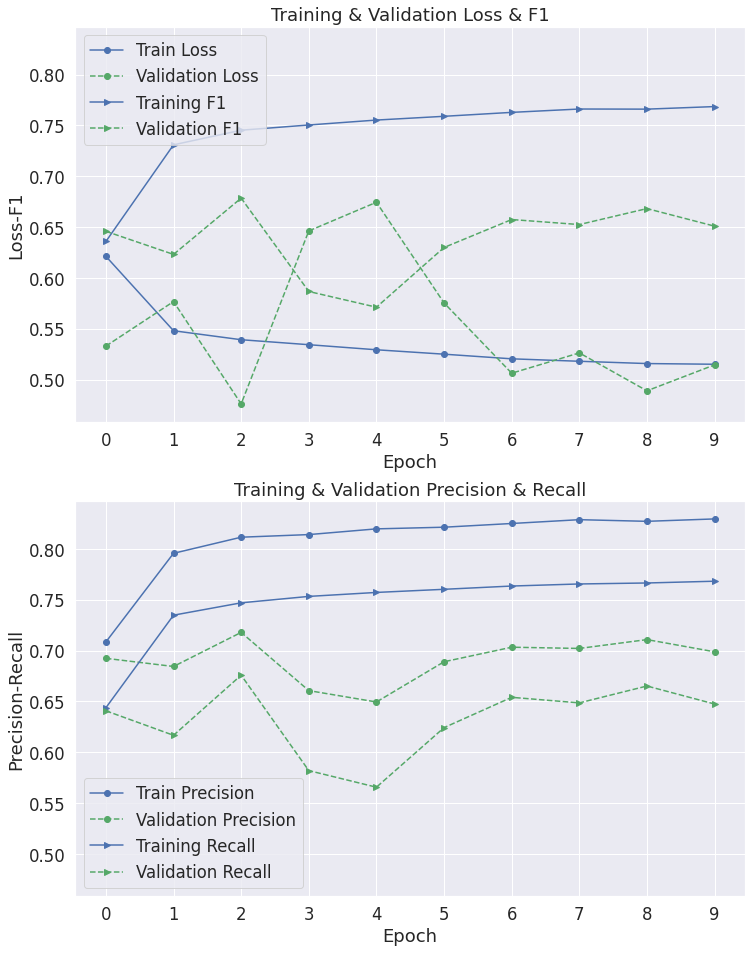

In [25]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)

# fig, ax = plt.subplots(figsize=(12, 8))    
fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=True, figsize=(12, 16))

# Plot the learning curve.
ax1.plot(res_df['train_loss'], 'b-o', label="Train Loss")
ax1.plot(res_df['valid_loss'], 'g--o', label="Validation Loss")

ax1.plot(res_df['train_f1'], 'b->', label="Training F1")
ax1.plot(res_df['valid_f1'], 'g-->', label="Validation F1")

ax2.plot(res_df['train_precision'], 'b-o', label="Train Precision")
ax2.plot(res_df['valid_precision'], 'g--o', label="Validation Precision")

ax2.plot(res_df['train_recall'], 'b->', label="Training Recall")
ax2.plot(res_df['valid_recall'], 'g-->', label="Validation Recall")

# Label the plot.
ax1.title.set_text("Training & Validation Loss & F1")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss-F1")
ax1.legend()
ax1.set_xticks(res_df['Epoch']-1)

ax2.title.set_text("Training & Validation Precision & Recall")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Precision-Recall")
ax2.legend()
ax2.set_xticks(res_df['Epoch']-1)

plt.show()

## Evaluation on Test Set


In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          path=None,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Parameters
    ----------
    cm: Confusion matrix provided by sklearn

    classes: list of class labels

    normalize: 'True' to normalize confusion matrix. "False" by default.

    path: String that contains the path to save the confusion matrix image

    title: title of the plot

    cmap: A matplotlib color map for the confusion matrix
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(9,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

    print("Saving image..")
    plt.savefig(path)
    print("Image saved at:", path)

    plt.show()

def xlnet_predict(model, test_df, path):
    """Perform a forward pass on the trained XLNet model to predict probabilities
    on the test set.

    Parameters
    ----------
    model: best model from training/validation step

    test_df: Dataframe for the test set being used

    path: Path for the confusion to be saved used by `plot_confusion_matrix()`

    """
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    all_labels = []
    all_predictions = []

    # Put the model into the evaluation mode. The dropout layers are disabled during the test time.
    model.eval()

    test_loader = DataLoader(test_df, batch_size = 8)

    for iter, (inputs, attns, labels) in enumerate(notebook.tqdm(test_loader, desc="Testing")):
        # putting inputs to device
        inputs = inputs.to(DEVICE)
        attns = attns.to(DEVICE)
        labels = labels.to(DEVICE)

        # feed to model
        with torch.no_grad():
            outputs = model(inputs,
                          token_type_ids=None, 
                          attention_mask=attns)
            logits = outputs[0]

            predictions = torch.argmax(logits, dim=-1)
            all_predictions += predictions.cpu().flatten().tolist()
            all_labels += labels.cpu().flatten().tolist()
            

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    conf_mat = confusion_matrix(all_labels, all_predictions)
    print("F1-score:", "%.2f%%" % (f1*100), "\n",
          "\nPrecision:", "%.2f%%" % (precision*100),
          "\nPrecision (CSAT=1): ", "%.2f%%" % (conf_mat[1][1] / (conf_mat[1][1] + conf_mat[0][1]) * 100),
          "\nPrecision (CSAT=0): ", "%.2f%%" % (conf_mat[0][0] / (conf_mat[0][0] + conf_mat[1][0]) * 100), "\n", 
          "\nRecall:", "%.2f%%" % (recall*100),
          "\nRecall (CSAT=1): ", "%.2f%%" % (conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0]) * 100),
          "\nRecall (CSAT=0): ", "%.2f%%" % (conf_mat[0][0] / (conf_mat[0][0] + conf_mat[0][1]) * 100), "\n"
    )
    plot_confusion_matrix(conf_mat, ["0","1"],path=path)

def get_idealized_dataset(encoded_text, encoded_labels):
    """
    Function that applies the latest preprocessing steps onto the old dataset to get the idealized version of the train/valid/test set
    """
    original_test_text = [tokenizer.decode(i,skip_special_tokens=True) for i in notebook.tqdm(encoded_text)]
    original_test_labels = encoded_labels.tolist()

    #convert the text and labels to a dataframe 
    d = {'text':original_test_text,'label':original_test_labels}
    df_test = pd.DataFrame(d, columns=['text','label'])
    df_test['text_length'] = df_test['text'].str.split().str.len()

    #Apply new preprocessing steps
    df_test_new_processed = exclude_disconnected_calls(df_test)
    return df_test_new_processed

In [ ]:
torch.cuda.empty_cache()


F1-score: 64.74% 
 
Precision: 64.54% 
Precision (CSAT=1):  86.71% 
Precision (CSAT=0):  42.36% 
 
Recall: 68.63% 
Recall (CSAT=1):  70.11% 
Recall (CSAT=0):  67.16% 

Confusion matrix, without normalization
Saving image..
Image saved at: /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/


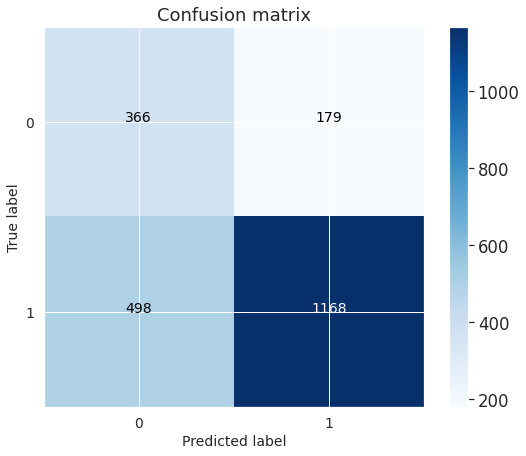

In [ ]:
saved_conf_mat_path = "/content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/"
saved_model_path= "/content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/saved_model_epoch_3"
test_model = XLNetForSequenceClassification.from_pretrained(saved_model_path).to('cuda')
xlnet_predict(test_model, test_df, saved_conf_mat_path)

In [31]:
def get_csat_ci(model, 
                test_df, 
                experiment_path = '/content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/',
                file_name = 'pred_lab.csv'):
  
    """Similar to xlnet_predict(). This function calculates evaluates the model on a given test set and saves the predictions and labels into a csv .

    Parameters
    ----------
    model: best model from training/validation step

    test_df: Dataframe for the test set being used

    experiment_path: Path where the desired model is stored

    file_name: Name of the csv file being saved.

    """
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    all_labels = []
    all_predictions = []

    # Put the model into the evaluation mode. The dropout layers are disabled during the test time.
    model.eval()

    test_loader = DataLoader(test_df, batch_size = 50)

    with open(experiment_path + file_name, 'w') as csvfile:
      fieldnames = ['predictions', 'labels']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',')
      writer.writeheader()

      for iter, (inputs, attns, labels) in enumerate(notebook.tqdm(test_loader, desc="Testing")):
          # putting inputs to device
          inputs = inputs.to(DEVICE)
          attns = attns.to(DEVICE)
          labels = labels.to(DEVICE)

          # feed to model
          with torch.no_grad():
              outputs = model(inputs,
                            token_type_ids=None, 
                            attention_mask=attns)
              logits = outputs[0]

              predictions = torch.argmax(logits, dim=-1)
              all_predictions += predictions.cpu().flatten().tolist()
              all_labels += labels.cpu().flatten().tolist()

              for i in range(len(predictions.cpu().flatten().tolist())):
                writer.writerow({'predictions': predictions.cpu().flatten().tolist()[i], 'labels': labels.cpu().flatten().tolist()[i]})

      precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
      conf_mat = confusion_matrix(all_labels, all_predictions)
      print("F1-score:", "%.2f%%" % (f1*100), "\n",
            "\nPrecision:", "%.2f%%" % (precision*100),
            "\nPrecision (CSAT=1): ", "%.2f%%" % (conf_mat[1][1] / (conf_mat[1][1] + conf_mat[0][1]) * 100),
            "\nPrecision (CSAT=0): ", "%.2f%%" % (conf_mat[0][0] / (conf_mat[0][0] + conf_mat[1][0]) * 100), "\n", 
            "\nRecall:", "%.2f%%" % (recall*100),
            "\nRecall (CSAT=1): ", "%.2f%%" % (conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0]) * 100),
            "\nRecall (CSAT=0): ", "%.2f%%" % (conf_mat[0][0] / (conf_mat[0][0] + conf_mat[0][1]) * 100), "\n"
      )

In [32]:
def get_companies_stderr(model, 
                         df,
                         list_of_companies,
                         saved_df):
  
    """Similar to xlnet_predict(). This function calculates evaluates the model on a given test set and saves the predictions and labels into a csv .

    Parameters
    ----------
    model: best model from training/validation step

    test_df: Dataframe for the test set being used

    experiment_path: Path where the desired model is stored

    file_name: Name of the csv file being saved.

    """
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    map_dict = {1: 5, 0: 1}
    # Put the model into the evaluation mode. The dropout layers are disabled during the test time.
    model.eval()

    for i in list_of_companies:
      all_labels = []
      all_predictions = []
      test_df = df[df['company_name'].str.contains(i)]
      text = test_df.text.values
      label = test_df.response_value.values

      #Get the last 768 tokens of calls that are > 768 tokens.
      ids_to_text = get_last_768_tokens(text)
      encoded_inputs = [tokenizer.encode_plus(inputs, max_length=770, pad_to_max_length=True, truncation=True, return_tensors='pt') for inputs in notebook.tqdm(ids_to_text)]

      #Creating a tensor dataset with the ENCODED inputs, labels and attention tensors.  
      test_inputs_tensor = torch.cat([x['input_ids'] for x in encoded_inputs])
      test_attn_tensor = torch.cat([x['attention_mask'] for x in encoded_inputs])
      test_labels_tensor = torch.LongTensor(label)

      test_df1 = TensorDataset(test_inputs_tensor, test_attn_tensor, test_labels_tensor) 

      test_loader = DataLoader(test_df1, batch_size = 50)

      for iter, (inputs, attns, labels) in enumerate(notebook.tqdm(test_loader, desc="Testing")):
        # putting inputs to device
        inputs = inputs.to(DEVICE)
        attns = attns.to(DEVICE)
        labels = labels.to(DEVICE)

        # feed to model
        with torch.no_grad():
            outputs = model(inputs,
                          token_type_ids=None, 
                          attention_mask=attns)
            logits = outputs[0]

            predictions = torch.argmax(logits, dim=-1)
            all_predictions += predictions.cpu().flatten().tolist()
            all_labels += labels.cpu().flatten().tolist()
        
        all_labels_mapped = [map_dict[i] if i in map_dict else i for i in all_labels]
        all_predictions_mapped = [map_dict[i] if i in map_dict else i for i in all_predictions]


      saved_df.loc[i] = [np.mean(all_labels_mapped), 
                         np.mean(all_predictions_mapped), 
                         np.std(all_labels_mapped)/np.sqrt(len(all_labels_mapped)), 
                         np.std(all_predictions_mapped)/np.sqrt(len(all_predictions_mapped))]
                         
    return saved_df.reset_index()

In [34]:
saved_model_path= "/content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/saved_model_epoch_3"
test_model = XLNetForSequenceClassification.from_pretrained(saved_model_path).to('cuda')

KeyboardInterrupt: ignored

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Fri Aug 28 15:57:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    34W / 250W |   1379MiB / 16280MiB |      9%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
saved_df = pd.DataFrame(columns = ['mean_csat', 'mean_pcsat', 'csat_stderr', 'pcsat_stderror'])
plot_df = get_companies_stderr(test_model, df, held_out_orgs, saved_df)

In [ ]:
plot_df.head(10)

,index,mean_csat,mean_pcsat,csat_stderr,pcsat_stderror
0,10 Fitness,4.353846,3.092308,0.074543,0.101166
1,Vinesse,4.500000,3.297297,0.076891,0.114956
2,Happy Home Appliance Repair Services,4.241379,3.482759,0.102952,0.127424
3,iNSYNQ LLC,1.706977,3.958140,0.104059,0.119728
4,Deputy,3.540284,2.535545,0.132567,0.133922
5,Rocket Matter,4.724138,4.200000,0.084173,0.132873
6,Service Legends,4.794118,4.705882,0.075787,0.089523
7,Roadrunner Financial,3.796992,2.443609,0.159057,0.166576
8,Ace Solves It All,4.720930,4.224806,0.089720,0.139207
9,CareLinx HR,3.836364,3.400000,0.173218,0.186840


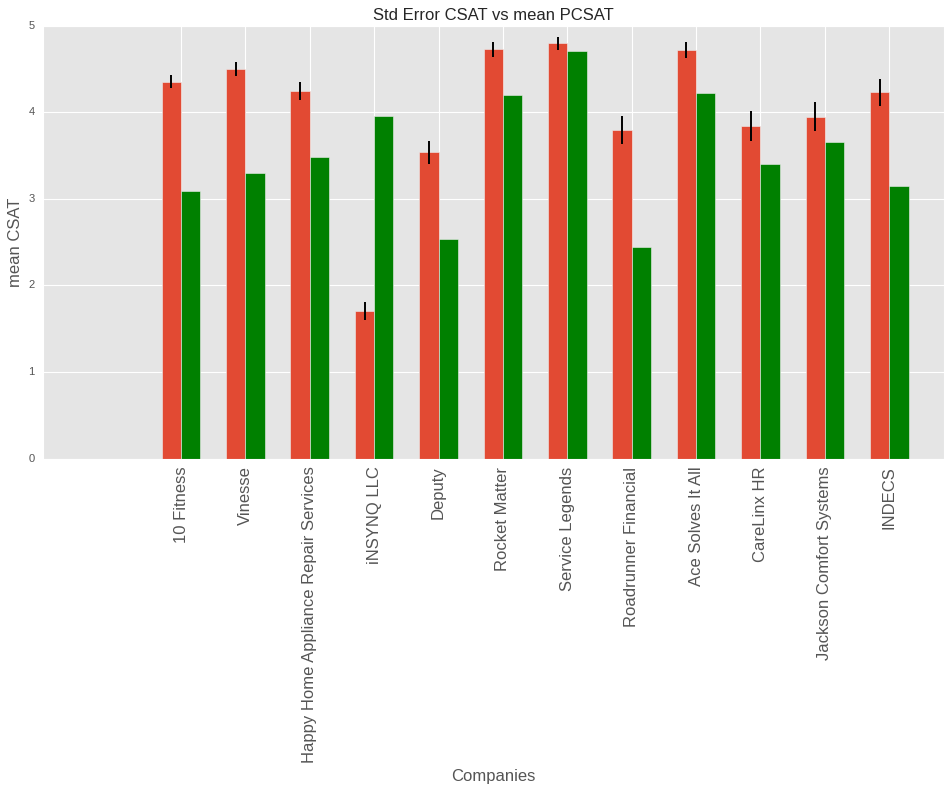

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
plt.style.use('ggplot')

ax1 = plt.bar(np.arange(len(plot_df.index)), plot_df.mean_csat, 0.3, yerr=plot_df.csat_stderr, align='center')
ax2 = plt.bar(np.arange(len(plot_df.index))+0.3, plot_df.mean_pcsat, 0.3, color='g', align='center')
plt.xlabel('Companies',size=15)
plt.ylabel('mean CSAT', size=15)
plt.title('Std Error CSAT vs mean PCSAT', size=15)

ax.set_xticks(np.arange(len(plot_df.index)) + 0.3/2 )
ax.set_xticklabels(plot_df['index'], rotation=90, size=15)

plt.tight_layout()
plt.show()

In [ ]:
qq = ['10 Fitness',
 'Vinesse',
 'Happy Home Appliance Repair Services',
 'iNSYNQ LLC',
 'Deputy',
 'Rocket Matter',
 'Service Legends',
 'Roadrunner Financial',
 'Ace Solves It All',
 'Jackson Comfort Systems',
 'CareLinx HR',
 'INDECS']

In [ ]:
for i in qq:
  print(df[df['company_name'].str.contains(i)].response_value.value_counts().sort_index()[0]/len(df[df['company_name'].str.contains(i)])*100)

16.153846153846153
12.5
18.96551724137931
82.32558139534883
36.492890995260666
6.896551724137931
5.147058823529411
30.075187969924812
6.976744186046512
26.36363636363636
29.09090909090909
19.230769230769234


In [ ]:
df_test[df_test['company_name'].str.contains('10 Fitness')].sort_values(by=['PARTITIONTIME'], ascending=False)['PARTITIONTIME'][51:75]
# test_dfdf_test[(df_test['company_name'].str.contains('10 Fitness')) & df_test['PARTITIONTIME'].between('2020-06-01','2020-06-08')].sort_values(by=['PARTITIONTIME'], ascending=False)

25347   2020-06-23 00:00:00+00:00
25554   2020-06-23 00:00:00+00:00
25231   2020-06-23 00:00:00+00:00
25233   2020-06-22 00:00:00+00:00
25588   2020-06-22 00:00:00+00:00
25531   2020-06-22 00:00:00+00:00
25235   2020-06-21 00:00:00+00:00
25350   2020-06-20 00:00:00+00:00
25237   2020-06-19 00:00:00+00:00
25544   2020-06-18 00:00:00+00:00
25333   2020-06-18 00:00:00+00:00
25453   2020-06-18 00:00:00+00:00
25399   2020-06-18 00:00:00+00:00
25297   2020-06-16 00:00:00+00:00
25555   2020-06-15 00:00:00+00:00
25545   2020-06-14 00:00:00+00:00
25395   2020-06-12 00:00:00+00:00
25280   2020-06-10 00:00:00+00:00
25518   2020-06-09 00:00:00+00:00
25264   2020-06-09 00:00:00+00:00
25592   2020-06-08 00:00:00+00:00
25405   2020-06-08 00:00:00+00:00
25388   2020-06-08 00:00:00+00:00
25355   2020-06-08 00:00:00+00:00
Name: PARTITIONTIME, dtype: datetime64[ns, UTC]

In [ ]:
# try_df = df[df['company_name'].str.contains('|'.join(qq))]
try_df = df[df['company_name'].str.contains('10 Fitness')]
#Encoding test set
text = try_df.text.values
label = try_df.response_value.values

#Get the last 768 tokens of calls that are > 768 tokens.
ids_to_text = get_last_768_tokens(text)
encoded_inputs = [tokenizer.encode_plus(inputs, max_length=770, pad_to_max_length=True, truncation=True, return_tensors='pt') for inputs in notebook.tqdm(ids_to_text)]

#Creating a tensor dataset with the ENCODED inputs, labels and attention tensors.  
test_inputs_tensor1 = torch.cat([x['input_ids'] for x in encoded_inputs])
test_attn_tensor1 = torch.cat([x['attention_mask'] for x in encoded_inputs])
test_labels_tensor1 = torch.LongTensor(label)

test_df1 = TensorDataset(test_inputs_tensor1, test_attn_tensor1, test_labels_tensor1) 

In [ ]:
get_csat_ci(test_model, test_df1)


F1-score: 60.77% 
 
Precision: 64.37% 
Precision (CSAT=1):  97.55% 
Precision (CSAT=0):  31.18% 
 
Recall: 76.46% 
Recall (CSAT=1):  60.86% 
Recall (CSAT=0):  92.06% 



In [ ]:
drive.mount('/content/gdrive')
pred_lab_path = "/content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v7/pred_lab.csv"
ci_df= pd.read_csv(pred_lab_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from sklearn.metrics import accuracy_score
from scipy import stats

In [ ]:
ci_df.labels.replace({1: 5, 0: 1},inplace=True)
ci_df.predictions.replace({1: 5, 0: 1},inplace=True)

In [ ]:
np.std(ci_df.labels) / np.sqrt(len(ci_df))

0.07454306261408296

In [ ]:
np.std(ci_df.predictions) / np.sqrt(len(ci_df))

0.10116601347240858

In [ ]:
ci_df.head()

,predictions,labels
0,1,5
1,5,5
2,1,5
3,5,5
4,1,5


In [ ]:
iterations = 10
lowerbounds_95 = []
upperbounds_95 = []
mean_pred = []
mean_lab = []
std_error_list = []

for itn in range(iterations):
  #get 100 random indices
  idx = np.random.choice(len(ci_df), size=30, replace=True)
  resampled_df = ci_df.iloc[idx]
  mean_pred.append(np.mean(resampled_df.predictions))

  mean_label = np.mean(resampled_df.labels)
  mean_lab.append(mean_label)
  std_error = np.std(resampled_df.labels) / np.sqrt(len(resampled_df))
  std_error_list.append(std_error)
  lower_bound_95 = mean_label - 1.96*std_error
  upper_bound_95 = mean_label + 1.96*std_error
  lowerbounds_95.append(lower_bound_95)
  upperbounds_95.append(upper_bound_95)

d = {'mean_predictions': mean_pred, 'mean_labels':mean_lab, 'lower_bound':lowerbounds_95, 'upper_bound':upperbounds_95, 'standard_error':std_error_list}
df1 = pd.DataFrame(d, columns = ["mean_predictions", "mean_labels", "lower_bound", "upper_bound", 'standard_error'])
df1["within_range"] = df1.mean_predictions.between(df1.lower_bound, df1.upper_bound)
df1["above"] = df1.mean_predictions.gt(df1.mean_labels)
df1["equal"] = df1.mean_predictions.eq(df1.mean_labels)
df1["lower"] = df1.mean_predictions.lt(df1.mean_labels)

In [ ]:
df1.head()

,mean_predictions,mean_labels,lower_bound,upper_bound,standard_error,within_range,above,equal,lower
0,2.466667,3.933333,3.300353,4.566314,0.322949,False,False,False,True
1,3.800000,4.333333,3.799889,4.866778,0.272166,True,False,False,True
2,2.600000,4.200000,3.627447,4.772553,0.292119,False,False,False,True
3,3.533333,3.933333,3.300353,4.566314,0.322949,True,False,False,True
4,2.733333,4.066667,3.461260,4.672073,0.308881,False,False,False,True


In [ ]:
val = df1.within_range.value_counts()[1] / (df1.within_range.value_counts()[0] + df1.within_range.value_counts()[1])*100
print("For {0:.2f}% of the 100-sample test set, the predicted mean is within the 95% confidence interval of the true CSAT mean ".format(val)) 

For 13.85% of the 100-sample test set, the predicted mean is within the 95% confidence interval of the true CSAT mean 


In [ ]:
iterations = 100000
lowerbounds_95 = []
upperbounds_95 = []
mean_pred = []
mean_lab = []

for itn in range(iterations):
  #get 100 random indices
  idx = np.random.choice(len(ci_df), size=100, replace=True)
  resampled_df = ci_df.iloc[idx]
  mean_pred.append(np.mean(resampled_df.predictions))

  mean_label = np.mean(resampled_df.labels)
  mean_lab.append(mean_label)
  std_error = np.std(resampled_df.labels) / np.sqrt(len(resampled_df))
  lower_bound_95 = mean_label - 2.576*std_error
  upper_bound_95 = mean_label + 2.576*std_error
  lowerbounds_95.append(lower_bound_95)
  upperbounds_95.append(upper_bound_95)

d = {'mean_predictions': mean_pred, 'mean_labels':mean_lab, 'lower_bound':lowerbounds_95, 'upper_bound':upperbounds_95}
df1 = pd.DataFrame(d, columns = ["mean_predictions", "mean_labels", "lower_bound", "upper_bound"])
df1["within_range"] = df1.mean_predictions.between(df1.lower_bound, df1.upper_bound)
df1["above"] = df1.mean_predictions.gt(df1.mean_labels)
df1["equal"] = df1.mean_predictions.eq(df1.mean_labels)
df1["lower"] = df1.mean_predictions.lt(df1.mean_labels)

In [ ]:
val = df1.within_range.value_counts()[1] / (df1.within_range.value_counts()[0] + df1.within_range.value_counts()[1])*100
print("For {0:.2f}% of the 100-sample test set, the predicted mean is within the 99% confidence interval of the true CSAT mean ".format(val)) 

For 28.00% of the 100-sample test set, the predicted mean is within the 99% confidence interval of the true CSAT mean 


In [ ]:
print("Equal:",df1.equal.value_counts()[1])
print("Higher:",df1.above.value_counts()[1])
print("Lower:",df1.lower.value_counts()[1])

print("% of predictions that are HIGHER than true mean:",  "%.2f%%" %(df1.above.value_counts()[1] / (df1.above.value_counts()[1] + df1.lower.value_counts()[1] + df1.equal.value_counts()[1])*100))
print("% of predictions that are LOWER than true mean:",  "%.2f%%" %(df1.lower.value_counts()[1] / (df1.above.value_counts()[1] + df1.lower.value_counts()[1] + df1.equal.value_counts()[1])*100))

Equal: 191
Higher: 236
Lower: 99573
% of predictions that are HIGHER than true mean: 0.24%
% of predictions that are LOWER than true mean: 99.57%


### Evaluating XLNet_never_seen_orgs model on idealized (connected calls) version of test set

---



In [ ]:
df_test_new = get_idealized_dataset(test_inputs_tensor,test_labels_tensor)

test_encoded_inputs = [tokenizer.encode_plus(inputs, add_special_tokens = True, max_length=770, pad_to_max_length=True, truncation=True, return_tensors='pt') for inputs in notebook.tqdm(df_test_new.text.values)]

#Creating a tensor dataset with the ENCODED inputs, labels and attention tensors.  
test_inputs_tensor = torch.cat([x['input_ids'] for x in test_encoded_inputs])
test_attn_tensor = torch.cat([x['attention_mask'] for x in test_encoded_inputs])
test_labels_tensor = torch.LongTensor(df_test_new.label.values)

test_df_new = TensorDataset(test_inputs_tensor, test_attn_tensor, test_labels_tensor) 


Applying new preprocesing steps...



F1-score: 66.29% 
 
Precision: 67.42% 
Precision (CSAT=1):  92.14% 
Precision (CSAT=0):  42.69% 
 
Recall: 65.37% 
Recall (CSAT=1):  93.69% 
Recall (CSAT=0):  37.06% 

Confusion matrix, without normalization
Saving image..
Image saved at: /content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v4/


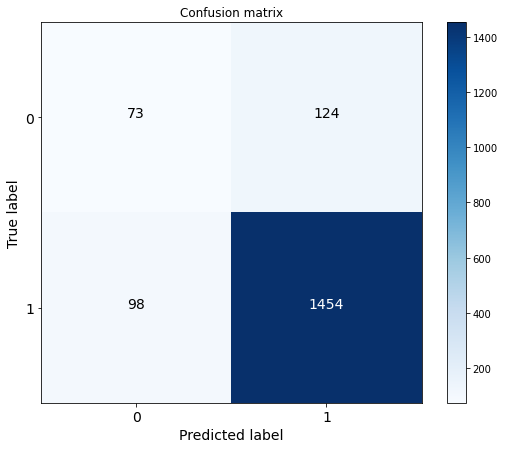

In [ ]:
saved_conf_mat_path = "/content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v4/"
saved_model_path= "/content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v4/saved_model_epoch_4"
test_model = XLNetForSequenceClassification.from_pretrained(saved_model_path).to('cuda')
xlnet_predict(test_model, test_df_new, saved_conf_mat_path)

In [ ]:
get_csat_ci(test_model, test_df_new, file_name='pred_lab_new.csv')


F1-score: 66.29% 
 
Precision: 67.42% 
Precision (CSAT=1):  92.14% 
Precision (CSAT=0):  42.69% 
 
Recall: 65.37% 
Recall (CSAT=1):  93.69% 
Recall (CSAT=0):  37.06% 



In [ ]:
drive.mount('/content/gdrive')
pred_lab_path = "/content/gdrive/My Drive/csatBERT/Experiment2/XLNet_768_v4/pred_lab_new.csv"
ci_df= pd.read_csv(pred_lab_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
iterations = 100000
lowerbounds_95 = []
upperbounds_95 = []
mean_pred = []
mean_lab = []

for itn in range(iterations):
  #get 100 random indices
  idx = np.random.choice(len(ci_df), size=100, replace=True)
  resampled_df = ci_df.iloc[idx]
  mean_pred.append(np.mean(resampled_df.predictions))

  mean_label = np.mean(resampled_df.labels)
  mean_lab.append(mean_label)
  std_error = np.std(resampled_df.labels) / np.sqrt(len(resampled_df))
  lower_bound_95 = mean_label - 1.96*std_error
  upper_bound_95 = mean_label + 1.96*std_error
  lowerbounds_95.append(lower_bound_95)
  upperbounds_95.append(upper_bound_95)

d = {'mean_predictions': mean_pred, 'mean_labels':mean_lab, 'lower_bound':lowerbounds_95, 'upper_bound':upperbounds_95}
df1 = pd.DataFrame(d, columns = ["mean_predictions", "mean_labels", "lower_bound", "upper_bound"])
df1["within_range"] = df1.mean_predictions.between(df1.lower_bound, df1.upper_bound)
df1["above"] = df1.mean_predictions.gt(df1.mean_labels)
df1["equal"] = df1.mean_predictions.eq(df1.mean_labels)
df1["lower"] = df1.mean_predictions.lt(df1.mean_labels)

In [ ]:
val = df1.within_range.value_counts()[1] / (df1.within_range.value_counts()[0] + df1.within_range.value_counts()[1])*100
print("For {0:.2f}% of the 100-sample test set, the predicted mean is within the 95% confidence interval of the true CSAT mean ".format(val)) 

For 89.81% of the 100-sample test set, the predicted mean is within the 95% confidence interval of the true CSAT mean 


In [ ]:
print("Equal:",df1.equal.value_counts()[1])
print("Higher:",df1.above.value_counts()[1])
print("Lower:",df1.lower.value_counts()[1])
print("% of predictions that are HIGHER than true mean:",  "%.2f%%" %(df1.above.value_counts()[1] / (df1.above.value_counts()[1] + df1.lower.value_counts()[1] + df1.equal.value_counts()[1])*100))
print("% of predictions that are LOWER than true mean:",  "%.2f%%" %(df1.lower.value_counts()[1] / (df1.above.value_counts()[1] + df1.lower.value_counts()[1] + df1.equal.value_counts()[1])*100))

Equal: 10287
Higher: 60906
Lower: 28807
% of predictions that are HIGHER than true mean: 60.91%
% of predictions that are LOWER than true mean: 28.81%
